In [1]:
import numpy as np
from pylab import *

import time
import res_utils as ru
import copy
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'text.usetex': False})

plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.family': 'serif', 'font.serif':['Arial']})

np.set_printoptions(precision=3)

In [2]:
def norm_range(v):
    return (v-v.min())/(v.max()-v.min())


def crvec(N, D=1):
    rphase = 2*np.pi * np.random.rand(int(D), int(N))
    return np.cos(rphase) + 1.0j * np.sin(rphase)


def scvec(N, D, K):
    letter_vectors_c = crvec(N, D)

    for d in range(D):
        ip = np.random.choice(int(N), size=int(N-K), replace=False)
        letter_vectors_c[d, ip] = 0

    return letter_vectors_c


def lccvec(N, D, K):
    # N needs to be multiple of K

    R = N/K

    assert (R == N//K)

    letter_vectors_c = 0*crvec(N, D)

    for d in range(D):
        ip = np.random.choice(int(R), size=int(K), replace=True)

        ip += int(R) * np.arange(int(K))

        letter_vectors_c[d, ip] = crvec(K, 1)

    return letter_vectors_c


def cconv(a, b, pa=1, pb=1):
    return ifft(fft(a)**pa * fft(b)**pb)


def ccinv(a):
    return ifft(np.conj(fft(a)))


def lccbind(vec1, vec2, Kv, pa=1, pb=1):
    Nv = vec1.shape[0]
    Rv = Nv/Kv

    vec1r = np.reshape(vec1, [int(Kv), int(Rv)])
    vec2r = np.reshape(vec2, [int(Kv), int(Rv)])

    vec_br = cconv(vec1r, vec2r, pa, pb)

    vec_b = vec_br.flatten()

    return vec_b


def lccperm(vec1, Kv, proll=1):
    Nv = vec1.shape[0]
    Rv = Nv/Kv

    vec1r = np.reshape(vec1, [int(Kv), int(Rv)])

    vec_perm = np.roll(vec1r, proll, axis=0)

    return vec_perm.flatten()


def lccinv(vec1, Kv):
    Nv = vec1.shape[0]
    Rv = Nv/Kv

    vec1r = np.reshape(vec1, [int(Kv), int(Rv)])

    vec1_ir = ccinv(vec1r)
    vec1_i = vec1_ir.flatten()

    return vec1_i


def update_resonator_digit_async(codebooks, resonator, scene):
    resonator_update = copy.copy(resonator)
    for i in range(len(codebooks)):
        new_code = scene
        for j in range(len(codebooks)):
            if i != j:
                new_code = new_code*(resonator_update[j, :]**-1)
        new_code = np.dot(codebooks[i].T, np.dot(
            np.conj(codebooks[i]), new_code.T))
#         new_code = np.dot(outer_products[i],new_code.T)
        new_code = new_code / np.abs(new_code)
        resonator_update[i, :] = new_code
    return resonator_update


def g(x):
    return x / np.abs(x)


def gen_res_digit(resonator, codebooks, max_iters, tree):
    res_hist = []
    res_curr = resonator
    for i in range(max_iters):
        res_hist.append(copy.copy(res_curr))
        res_curr = update_resonator_digit_async(codebooks, res_curr, tree)
        if np.mean(np.cos(np.angle(np.ndarray.flatten(res_curr))-np.angle(np.ndarray.flatten(res_hist[-1])))) > 0.99:
            break
    res_hist.append(copy.copy(res_curr))
#         print i
    return i+1, res_hist


def dot_complex(vec1, vec2):
    num = np.dot(np.conj(vec1), vec2)
    denom = np.linalg.norm(vec1)*np.linalg.norm(vec2)
#     return np.abs(num)/denom)*np.linalg.norm(vec2)
    return np.abs(num)/denom

In [20]:
prime_set = []
# for num in range(2,21):
for num in range(2, 301):
    for i in range(2, num):
        if (num % i == 0):
            break
    else:
        prime_set.append(num)
print(prime_set)
hd_dims = np.round(2**np.arange(1, 12, 0.2)).astype(int)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293]


In [21]:
n_trials = 20

acc = np.zeros((len(hd_dims), len(prime_set)-2))
breaks = np.zeros((len(prime_set)))
# for i in range(len(hd_dims)):
#     v_size = hd_dims[i]
reset = 0
for j in range(len(prime_set)-2):
    bases = prime_set[j:j+2]
    for i in range(reset, len(hd_dims)):
        v_size = hd_dims[i]
        for k in range(n_trials):
            seed_vecs = []
            for m in range(len(bases)):
                seed_vecs.append(ru.cvecl(v_size, loopsize=bases[m]))

            codebooks = []
            for m in range(len(bases)):
                samp_code = np.random.normal(0.0, 1.0, size=(
                    bases[m], v_size)) + 1j*np.random.normal(0.0, 1.0, size=(bases[m], v_size))
                samp_code = samp_code*0
                codebooks.append(samp_code)

            for m in range(len(bases)):
                for n in range(bases[m]):
                    codebooks[m][n, :] = np.power(seed_vecs[m], n)

            resonator = np.ones((len(bases), v_size), dtype=complex)
            for m in range(len(codebooks)):
                resonator[m, :] = np.random.normal(0.0, 1.0, size=(
                    1, v_size)) + 1j*np.random.normal(0.0, 1.0, size=(1, v_size))
                resonator[m, :] = resonator[m, :] / np.abs(resonator[m, :])

            num_iters = 50
            key = np.random.randint(0, bases[0]*bases[1])

            scene = np.ones((v_size,), dtype=complex)
            for m in range(len(bases)):
                scene *= np.power(seed_vecs[m], key)

            n_updates, res_hist = gen_res_digit(
                resonator, codebooks, num_iters, scene)

            progs = []
            for m in range(len(bases)):
                c = codebooks[m]
                corrs = np.zeros((n_updates, c.shape[0]), dtype=complex)
                for n in range(n_updates-1, n_updates):
                    for p in range(c.shape[0]):
                        # codebooks[m][p,:])
                        corrs[n, p] = dot_complex(c[p, :], res_hist[n][m, :])
                progs.append(corrs)

            acc[i, j] += (np.argmax(progs[0][-1, :]) == key %
                          bases[0])*(np.argmax(progs[1][-1, :]) == key % bases[1])

        print(hd_dims[i], np.prod(bases), acc[i, j]/n_trials)
        if (acc[i, j]/n_trials >= .99):
            breaks[j] = i
            reset = i
            break

2 6 0.35
2 6 0.35
3 6 0.45
3 6 0.6
3 6 0.65
4 6 0.75
5 6 0.85
5 6 0.75
6 6 1.0
6 15 0.85
7 15 0.95
8 15 0.95
9 15 1.0
9 35 0.75
11 35 0.85
12 35 0.75
14 35 0.85
16 35 1.0
16 77 0.55
18 77 0.75
21 77 0.85
24 77 0.95
28 77 1.0
28 143 0.8
32 143 0.9
37 143 1.0
37 221 0.75
42 221 0.95
49 221 0.9
56 221 1.0
56 323 0.95
64 323 0.95
74 323 1.0
74 437 0.9
84 437 1.0
84 667 0.95
97 667 0.95
111 667 0.95
128 667 0.95
147 667 1.0
147 899 1.0
147 1147 1.0
147 1517 0.95
169 1517 1.0
169 1763 1.0
169 2021 1.0
169 2491 0.9
194 2491 0.95
223 2491 1.0
223 3127 1.0
223 3599 0.95
256 3599 1.0
256 4087 1.0
256 4757 1.0
256 5183 0.95
294 5183 1.0
294 5767 1.0
294 6557 0.95
338 6557 1.0
338 7387 0.9
388 7387 1.0
388 8633 1.0
388 9797 0.95
446 9797 1.0
446 10403 1.0
446 11021 1.0
446 11663 1.0
446 12317 0.95
512 12317 1.0
512 14351 1.0
512 16637 1.0
512 17947 0.9
588 17947 1.0
588 19043 1.0
588 20711 1.0
588 22499 0.95
676 22499 1.0
676 23707 1.0
676 25591 1.0
676 27221 1.0
676 28891 1.0
676 30967 1.0
676 32

In [24]:
caps = np.zeros(len(prime_set)-4)
critnum = np.zeros(len(prime_set)-4)
for i in range(len(prime_set)-4):
    caps[i] = prime_set[i]*prime_set[i+1]
    critnum[i] = hd_dims[int(breaks[i])]

In [25]:
np.savez('2mods_resultsv2.npz', caps=caps, critnum=critnum)

In [8]:
prime_set = []
# for num in range(2,21):
for num in range(2, 51):
    for i in range(2, num):
        if (num % i == 0):
            break
    else:
        prime_set.append(num)
print(prime_set)
hd_dims = np.round(np.arange(128, 15001, 128)).astype(int)
hd_dims = np.round(2**np.arange(4, 14, 0.2)).astype(int)
# print(hd_dims)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]


In [9]:
n_trials = 20
# n_trials = 200 to fully visualize the trend

acc2 = np.zeros((len(hd_dims), len(prime_set)-2))
breaks2 = np.zeros((len(hd_dims)))*(n_trials)
# for i in range(len(hd_dims)):
#     v_size = hd_dims[i]
reset = 0
for j in range(len(prime_set)-2):
    bases = prime_set[j:j+3]
    for i in range(reset, len(hd_dims)):
        v_size = hd_dims[i]
        for k in range(n_trials):
            seed_vecs = []
            for m in range(len(bases)):
                seed_vecs.append(ru.cvecl(v_size, loopsize=bases[m]))

            codebooks = []
            for m in range(len(bases)):
                samp_code = np.random.normal(0.0, 1.0, size=(
                    bases[m], v_size)) + 1j*np.random.normal(0.0, 1.0, size=(bases[m], v_size))
                samp_code = samp_code*0
                codebooks.append(samp_code)

            for m in range(len(bases)):
                for n in range(bases[m]):
                    codebooks[m][n, :] = np.power(seed_vecs[m], n)

            resonator = np.ones((len(bases), v_size), dtype=complex)
            for m in range(len(codebooks)):
                resonator[m, :] = np.random.normal(0.0, 1.0, size=(
                    1, v_size)) + 1j*np.random.normal(0.0, 1.0, size=(1, v_size))
                resonator[m, :] = resonator[m, :] / np.abs(resonator[m, :])

            num_iters = 50
            key = np.random.randint(0, bases[0]*bases[1]*bases[2])

            scene = np.ones((v_size,), dtype=complex)
            for m in range(len(bases)):
                scene *= np.power(seed_vecs[m], key)

            n_updates, res_hist = gen_res_digit(
                resonator, codebooks, num_iters, scene)

            progs = []
            for m in range(len(bases)):
                c = codebooks[m]
                corrs = np.zeros((n_updates, c.shape[0]), dtype=complex)
                for n in range(n_updates-1, n_updates):
                    for p in range(c.shape[0]):
                        # codebooks[m][p,:])
                        corrs[n, p] = dot_complex(c[p, :], res_hist[n][m, :])
                progs.append(corrs)

            acc2[i, j] += (np.argmax(progs[0][-1, :]) == key % bases[0])*(np.argmax(
                progs[1][-1, :]) == key % bases[1])*(np.argmax(progs[2][-1, :]) == key % bases[2])

        print(hd_dims[i], np.prod(bases), acc2[i, j]/n_trials)
        if (acc2[i, j]/n_trials >= .99):
            breaks2[j] = i
            reset = i
            break

16 30 0.95
18 30 0.75
21 30 0.9
24 30 0.9
28 30 0.95
32 30 0.85
37 30 1.0
37 105 0.8
42 105 0.9
49 105 1.0
49 385 0.8
56 385 0.8
64 385 0.8
74 385 0.65
84 385 0.75
97 385 0.9
111 385 0.85
128 385 0.95
147 385 0.9
169 385 1.0
169 1001 0.9
194 1001 1.0
194 2431 0.75
223 2431 0.95
256 2431 0.8
294 2431 0.85
338 2431 0.9
388 2431 0.95
446 2431 0.9
512 2431 1.0
512 4199 0.7
588 4199 0.95
676 4199 0.95
776 4199 0.95
891 4199 1.0
891 7429 0.9
1024 7429 1.0
1024 12673 0.9
1176 12673 0.95
1351 12673 0.9
1552 12673 0.9
1783 12673 1.0
1783 20677 1.0
1783 33263 0.8
2048 33263 0.95
2353 33263 0.85
2702 33263 1.0
2702 47027 0.95
3104 47027 1.0
3104 65231 0.85
3566 65231 1.0
3566 82861 0.95
4096 82861 1.0


In [10]:
caps3 = np.zeros(len(prime_set)-4)
critnum3 = np.zeros(len(prime_set)-4)
for i in range(len(prime_set)-4):
    caps3[i] = prime_set[i]*prime_set[i+1]*prime_set[i+2]
    critnum3[i] = hd_dims[int(breaks2[i])]

In [11]:
np.savez('3mods_resultsv2.npz', caps3=caps3, critnum3=critnum3)

In [55]:
prime_set = []
# for num in range(2,21):
for num in range(2, 30):
    for i in range(2, num):
        if (num % i == 0):
            break
    else:
        prime_set.append(num)
print(prime_set)
hd_dims = np.round(np.arange(128, 20000.1, 128)).astype(int)
hd_dims = np.round(2**np.arange(7, 16, 0.5)).astype(int)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]


In [56]:
n_trials = 20

acc3 = np.zeros((len(hd_dims), len(prime_set)-3))
breaks3 = np.zeros((len(hd_dims)))*(n_trials)

reset = 0
for j in range(len(prime_set)-3):
    bases = prime_set[j:j+4]
    for i in range(reset, len(hd_dims)):
        v_size = hd_dims[i]
        for k in range(n_trials):
            seed_vecs = []
            for m in range(len(bases)):
                seed_vecs.append(ru.cvecl(v_size, loopsize=bases[m]))

            codebooks = []
            for m in range(len(bases)):
                samp_code = np.random.normal(0.0, 1.0, size=(
                    bases[m], v_size)) + 1j*np.random.normal(0.0, 1.0, size=(bases[m], v_size))
                samp_code = samp_code*0
                codebooks.append(samp_code)

            for m in range(len(bases)):
                for n in range(bases[m]):
                    codebooks[m][n, :] = np.power(seed_vecs[m], n)

            resonator = np.ones((len(bases), v_size), dtype=complex)
            for m in range(len(codebooks)):
                resonator[m, :] = np.random.normal(0.0, 1.0, size=(
                    1, v_size)) + 1j*np.random.normal(0.0, 1.0, size=(1, v_size))
                resonator[m, :] = resonator[m, :] / np.abs(resonator[m, :])

            num_iters = 50
            key = np.random.randint(0, bases[0]*bases[1]*bases[2]*bases[3])

            scene = np.ones((v_size,), dtype=complex)
            for m in range(len(bases)):
                scene *= np.power(seed_vecs[m], key)

            n_updates, res_hist = gen_res_digit(
                resonator, codebooks, num_iters, scene)

            progs = []
            for m in range(len(bases)):
                c = codebooks[m]
                corrs = np.zeros((n_updates, c.shape[0]), dtype=complex)
                for n in range(n_updates-1, n_updates):
                    for p in range(c.shape[0]):
                        # codebooks[m][p,:])
                        corrs[n, p] = dot_complex(c[p, :], res_hist[n][m, :])
                progs.append(corrs)

            acc3[i, j] += (np.argmax(progs[0][-1, :]) == key % bases[0])*(np.argmax(progs[1][-1, :]) == key %
                                                                          bases[1])*(np.argmax(progs[2][-1, :]) == key % bases[2])**(np.argmax(progs[3][-1, :]) == key % bases[3])

        print(hd_dims[i], np.prod(bases), acc3[i, j]/n_trials)
        if (acc3[i, j]/n_trials >= .99):
            breaks3[j] = i
            reset = i
            break

128 210 0.9
181 210 0.9
256 210 1.0


256 1155 0.8
362 1155 0.75
512 1155 0.8
724 1155 0.95
1024 1155 1.0
1024 5005 0.75
1448 5005 0.85
2048 5005 1.0
2048 17017 0.9
2896 17017 0.8
4096 17017 0.9
5793 17017 0.95
8192 17017 1.0
8192 46189 0.85
11585 46189 0.95
16384 46189 1.0
16384 96577 0.95
23170 96577 1.0
23170 215441 0.9
32768 215441 0.9
46341 215441 1.0


In [57]:
caps4 = np.zeros(len(prime_set)-4)
critnum4 = np.zeros(len(prime_set)-4)
for i in range(len(prime_set)-4):
    caps4[i] = prime_set[i]*prime_set[i+1]*prime_set[i+2]*prime_set[i+3]
    critnum4[i] = hd_dims[int(breaks3[i])]

In [58]:
np.savez('4mods_resultsv2.npz', caps4=caps4, critnum4=critnum4)

In [26]:
colors = ['darkblue', 'tab:orange', 'darkviolet', 'seagreen']
colors = colors[0:3]

In [59]:
caps = np.load('2mods_resultsv2.npz')['caps']
critnum = np.load('2mods_resultsv2.npz')['critnum']

caps3 = np.load('3mods_resultsv2.npz')['caps3']
critnum3 = np.load('3mods_resultsv2.npz')['critnum3']

caps4 = np.load('4mods_resultsv2.npz')['caps4']
critnum4 = np.load('4mods_resultsv2.npz')['critnum4']

[ 1.742 -1.42 ]
[ 1.523 -1.659]
[ 1.318 -1.924]


Text(0.5, 0, 'log(Vector dimension)')

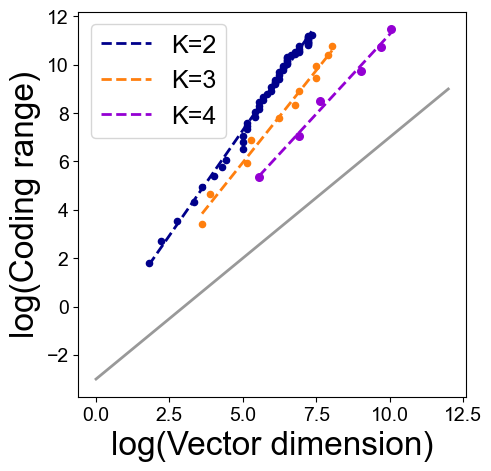

In [60]:
figure(figsize=(5, 5), dpi=100)
scatter(np.log(critnum), np.log(caps), s=20, c=colors[0])
scatter(np.log(critnum3), np.log(caps3), s=20, c=colors[1])
scatter(np.log(critnum4), np.log(caps4), s=30, c=colors[2])
# scatter(np.log(caps5),np.log(critnum5),s=60)

model1 = np.poly1d(np.polyfit(np.log(critnum), np.log(caps), 1))
polyline = np.linspace(np.log(np.min(critnum)), np.log(np.max(critnum)), 100)
plot(polyline, model1(polyline), '--', lw=2, label='K=2', c=colors[0])
print(model1.coeffs)

model2 = np.poly1d(np.polyfit(np.log(critnum3), np.log(caps3), 1))
polyline2 = np.linspace(np.log(np.min(critnum3)),
                        np.log(np.max(critnum3)), 100)
plot(polyline2, model2(polyline2), '--', lw=2, label='K=3', c=colors[1])

print(model2.coeffs)

model3 = np.poly1d(np.polyfit(np.log(critnum4), np.log(caps4), 1))
polyline3 = np.linspace(np.log(np.min(critnum4)),
                        np.log(np.max(critnum4)), 100)
plot(polyline3, model3(polyline3), '--', lw=2, label='K=4', c=colors[2])
print(model3.coeffs)

plot(np.linspace(0, 12, 100), np.linspace(
    0, 12, 100)-3, '-', lw=2, c='black', alpha=0.4)

# model5 = np.poly1d(np.polyfit(np.log(caps5),np.log(critnum5), 1))
# polyline5 = np.linspace(np.log(np.min(caps5)), np.log(np.max(caps5)), 100)
# plot(polyline5, model5(polyline5),'--',lw=2,label='5 factors')
# print(model5.coeffs)
legend(fontsize=18)
# xscale('log')
# xlim([2, 12])
# ylim([2, 12])

ylabel('log(Coding range)', fontsize=24)
xlabel('log(Vector dimension)', fontsize=24)

(0.8, 2.2)

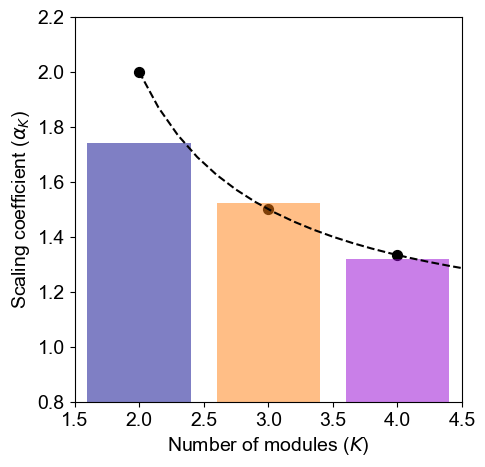

In [61]:
figure(figsize=(5, 5), dpi=100)
scatter([2, 3, 4], [2, 1.5, 4./3], s=50, color='black')
# plot([2,3,4],[0.5,2./3,3./4])
bar([2, 3, 4], [model1.coeffs[0], model2.coeffs[0],
    model3.coeffs[0]], color=colors, alpha=0.5)
x_sp = np.linspace(2, 5, 21)
plot(x_sp, (x_sp)/(x_sp-1), '--', color='black')
# plot([2,3,4],[0.533,0.595,0.8])
xlabel('Number of modules ($\it{K}$)')
ylabel('Scaling coefficient ($\\alpha_K$)')
xlim(1.5, 4.5)
ylim(.8, 2.2)